In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [17]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

# Section 0: Data cleaning and download

In [110]:
path = '/Users/rodrigo/Library/Mobile Documents/com~apple~CloudDocs/UChicago/2026_1_Quarter/35137 Machine Learning in Finance/Homeworks/Homework_1/Source/'
sp_file = "gw.csv"
other_variables_file = "FREDMD.csv"

In [4]:
df_equity = pd.read_csv(path + sp_file)
df_equity["yyyymm"] = pd.to_datetime(df_equity["yyyymm"], format = "%Y%m")
df_equity.rename(columns = {"yyyymm": "date"}, inplace = True)
df_equity.set_index("date", inplace = True)
df_equity.head()

,dfy_lag1,infl_lag1,svar_lag1,de_lag1,lty_lag1,tms_lag1,tbl_lag1,dfr_lag1,dp_lag1,dy_lag1,ltr_lag1,ep_lag1,b/m_lag1,ntis_lag1,CRSP_SPvw_minus_Rfree
date,,,,,,,,,,,,,,,
1927-01-01,0.0100,0.000000,0.000465,-0.586175,0.0354,0.0047,0.0307,-0.0022,-2.973012,-2.956570,0.0078,-2.386837,0.441476,0.050876,-0.005410
1927-02-01,0.0095,-0.011299,0.000470,-0.567601,0.0351,0.0028,0.0323,-0.0019,-2.942374,-2.963349,0.0075,-2.374773,0.443706,0.050824,0.042922
1927-03-01,0.0092,-0.005714,0.000287,-0.549182,0.0347,0.0018,0.0329,-0.0019,-2.979535,-2.932946,0.0088,-2.430353,0.428501,0.051668,0.004324
1927-04-01,0.0092,-0.005747,0.000924,-0.531456,0.0331,0.0011,0.0320,-0.0170,-2.976535,-2.970053,0.0253,-2.445079,0.469765,0.046357,0.010521
1927-05-01,0.0090,0.000000,0.000603,-0.512916,0.0333,-0.0006,0.0339,0.0060,-2.984225,-2.967143,-0.0005,-2.471309,0.456754,0.050514,0.059353


# Section 1

Download the file __gw.csv__ from canvas. This file contains monthly S&P 500 index returns along with a series of predictors used to forecast the market. The S&P returns are offset by one month from the predictors. In the first part of the problem set we will explore how well
we can forecast market returns using machine learning methods.


## Exercise 1

For each of the predictors, regress the S&P 500 index returns on the predictor using the full sample of data. Report the $R^2$ values of these regressions.

In [5]:
dep_variable = "CRSP_SPvw_minus_Rfree"
indep_variable_list = [x for x in df_equity.columns if x != dep_variable]

In [6]:
#Calculating Rsquared per variable using full data
y_historical = df_equity[dep_variable].to_numpy()
info_list = []

for indep_variable in indep_variable_list:
    X_historical = df_equity[[indep_variable]].to_numpy()

    linear_model = LinearRegression()
    linear_model.fit(X_historical, y_historical)

    linear_beta = linear_model.coef_[0]
    linear_alpha = linear_model.intercept_

    y_hat_historical = linear_model.predict(X_historical)
    r2_in_sample = r2_score(y_historical, y_hat_historical)

    info_list.append([indep_variable, linear_alpha, linear_beta, r2_in_sample])

df_exercise_1_1 = pd.DataFrame(info_list, columns = ["variable", "alpha", "beta", "r_squared"])
df_exercise_1_1.set_index("variable", inplace=True)

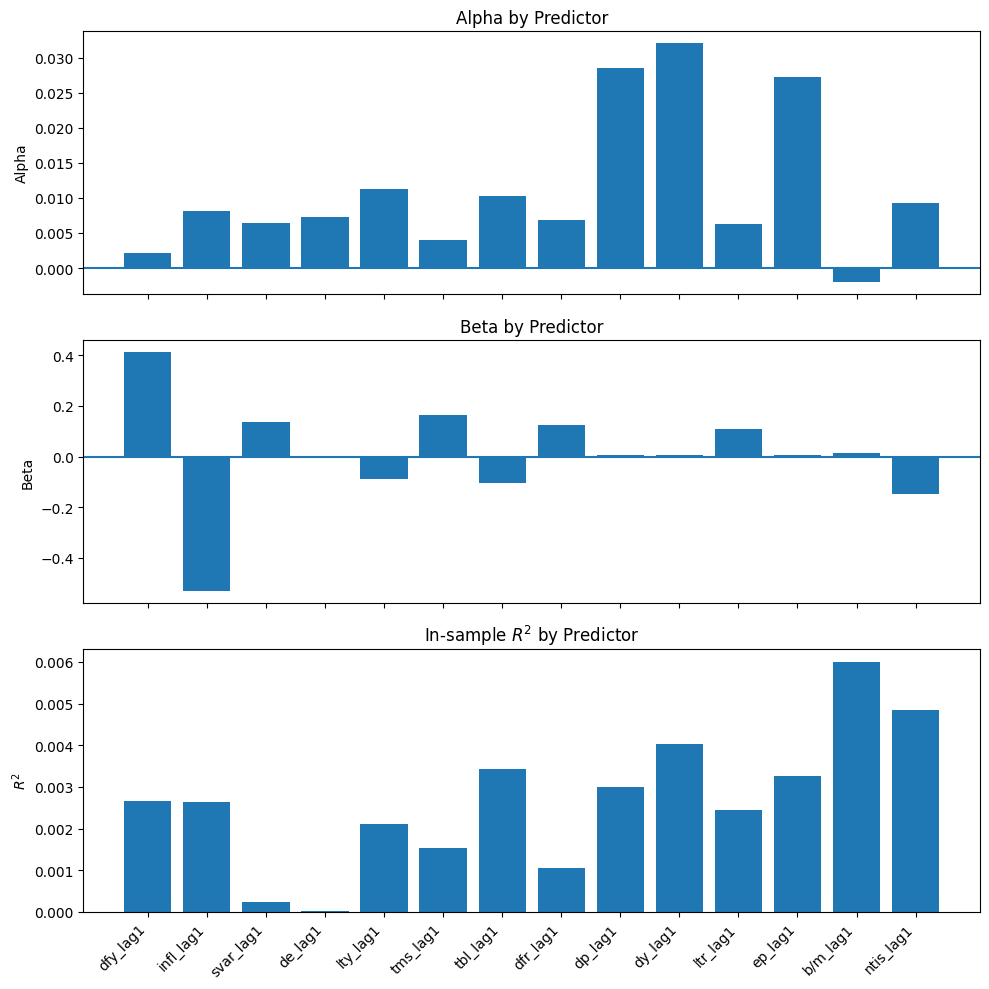

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Alpha
axes[0].bar(df_exercise_1_1.index, df_exercise_1_1["alpha"])
axes[0].axhline(0)
axes[0].set_title("Alpha by Predictor")
axes[0].set_ylabel("Alpha")

# Beta
axes[1].bar(df_exercise_1_1.index, df_exercise_1_1["beta"])
axes[1].axhline(0)
axes[1].set_title("Beta by Predictor")
axes[1].set_ylabel("Beta")

# R-squared
axes[2].bar(df_exercise_1_1.index, df_exercise_1_1["r_squared"])
axes[2].set_title("In-sample $R^2$ by Predictor")
axes[2].set_ylabel("$R^2$")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Next, evaluate the out-of-sample performance of each predictor individually using an expanding sample of data starting in 1965. Compute the out-of-sample $R^2$ and compare it to the in-sample $R^2$.

In [8]:
starting_date = pd.to_datetime("1964-12-31")
list_future_dates = df_equity[df_equity.index > starting_date].index.to_list()

In [9]:
#Calculating Rsquared per variable using a rolling window
info_list_errors = [] 
for future_date in list_future_dates:
    df_equity_aux_train = df_equity[df_equity.index < future_date]
    df_equity_aux_test = df_equity[df_equity.index == future_date]
    
    y_rolling = df_equity_aux_train[dep_variable].to_numpy()
    y_rolling_test = df_equity_aux_test[dep_variable].to_numpy()

    for indep_variable in indep_variable_list:
        X_rolling = df_equity_aux_train[[indep_variable]].to_numpy()
        X_rolling_test = df_equity_aux_test[[indep_variable]].to_numpy()

        linear_model = LinearRegression()
        linear_model.fit(X_rolling, y_rolling)

        y_hat_rolling = linear_model.predict(X_rolling_test)

        squared_forecast_error = (y_rolling_test - y_hat_rolling) ** 2
        squared_benchmark_error = (y_rolling_test - y_rolling.mean()) ** 2

        info_list_errors.append([future_date,indep_variable, squared_forecast_error[0], squared_benchmark_error[0]])


df_exercise_1_2 = pd.DataFrame(info_list_errors, columns = ["date", "variable", "squared_forecast_error", "squared_benchmark_error"])
df_exercise_1_2 = df_exercise_1_2[["variable", "squared_forecast_error", "squared_benchmark_error"]].groupby(by = ["variable"]).sum()
df_exercise_1_2["r_squared_oos"] = 1 - (df_exercise_1_2["squared_forecast_error"] / df_exercise_1_2["squared_benchmark_error"])

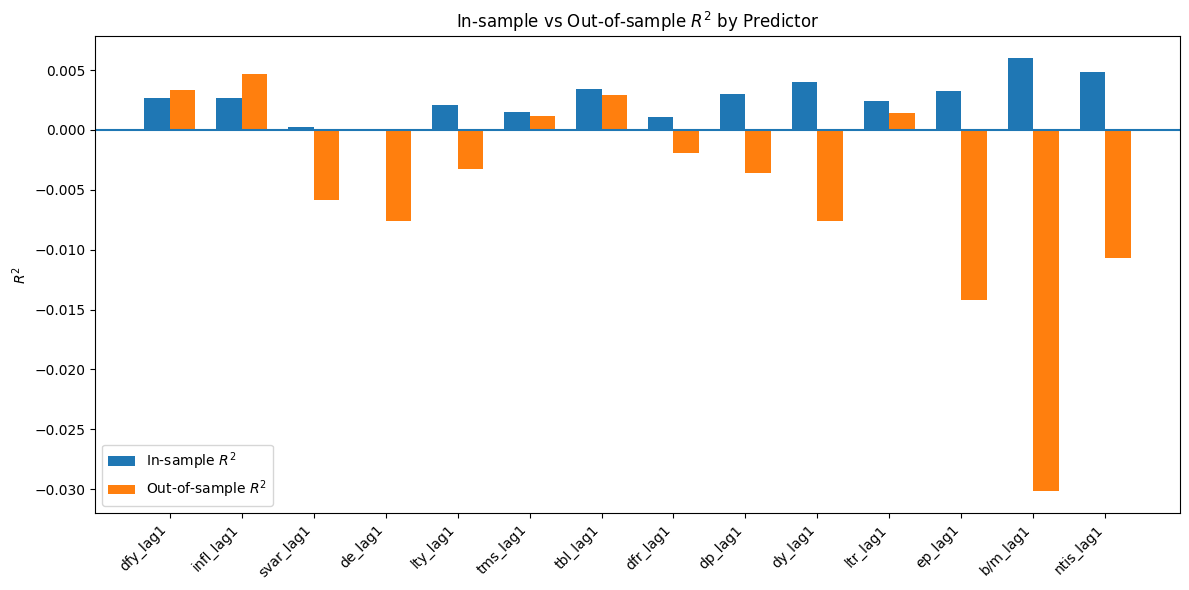

In [10]:
df_errors = pd.concat([df_exercise_1_1[["r_squared"]], df_exercise_1_2[["r_squared_oos"]]], axis = 1)

variables = df_errors.index
r2_is = df_errors["r_squared"].values
r2_oos = df_errors["r_squared_oos"].values

x = np.arange(len(variables))
width = 0.35

plt.figure(figsize=(12, 6))

plt.bar(x - width/2, r2_is, width, label="In-sample $R^2$")
plt.bar(x + width/2, r2_oos, width, label="Out-of-sample $R^2$")

plt.axhline(0)
plt.xticks(x, variables, rotation=45, ha="right")
plt.ylabel("$R^2$")
plt.title("In-sample vs Out-of-sample $R^2$ by Predictor")
plt.legend()

plt.tight_layout()
plt.show()

Interpret these results and discuss what they imply about the usefulness of these predictors for forecasting market returns.

__The graph shows that the in-sample $R^2$ values are higher than the out-of-sample $R^2$ values. However, it is important to note that in the in-sample exercise, the same data are used both to fit and to evaluate the model. As a result, the model may learn the behavior of the data rather than truly predicting it, which can lead to overfitting.__

__On the other hand, although the out-of-sample metrics are lower, they are computed using two different samples: the model is fitted using past data and evaluated using future data. Therefore, the out-of-sample $R^2$ provides a more realistic measure of predictive performance.__

__The use of machine learning models in finance depends on the objective of the analysis. If the goal is to explain or understand past behavior, in-sample results can be useful. However, if the objective is forecasting, out-of-sample performance is more appropriate and informative.__


## Exercise 2

Next, try the same expanding sample exercise but include all the predictors in a single regression. Compare the out-of-sample $R^2$ obtained here to those in part (a). 

In [11]:
#Calculating Rsquared per variable using a rolling window
info_list_errors_multivariable = [] 

for future_date in list_future_dates:
    df_equity_aux_train = df_equity[df_equity.index < future_date]
    df_equity_aux_test = df_equity[df_equity.index == future_date]
    
    y_rolling = df_equity_aux_train[dep_variable].to_numpy()
    y_rolling_test = df_equity_aux_test[dep_variable].to_numpy()

    X_rolling = df_equity_aux_train[indep_variable_list].to_numpy()
    X_rolling_test = df_equity_aux_test[indep_variable_list].to_numpy()

    linear_model = LinearRegression()
    linear_model.fit(X_rolling, y_rolling)

    y_hat_rolling = linear_model.predict(X_rolling_test)

    squared_forecast_error = (y_rolling_test - y_hat_rolling) ** 2
    squared_benchmark_error = (y_rolling_test - y_rolling.mean()) ** 2

    info_list_errors_multivariable.append([future_date, squared_forecast_error[0], squared_benchmark_error[0]])


df_exercise_2_1 = pd.DataFrame(info_list_errors_multivariable, columns = ["date", "squared_forecast_error", "squared_benchmark_error"])
df_exercise_2_1.set_index("date", inplace = True)
df_exercise_2_1 = df_exercise_2_1.cumsum()
df_exercise_2_1["r_squared_oos"] = 1 - (df_exercise_2_1["squared_forecast_error"] / df_exercise_2_1["squared_benchmark_error"])

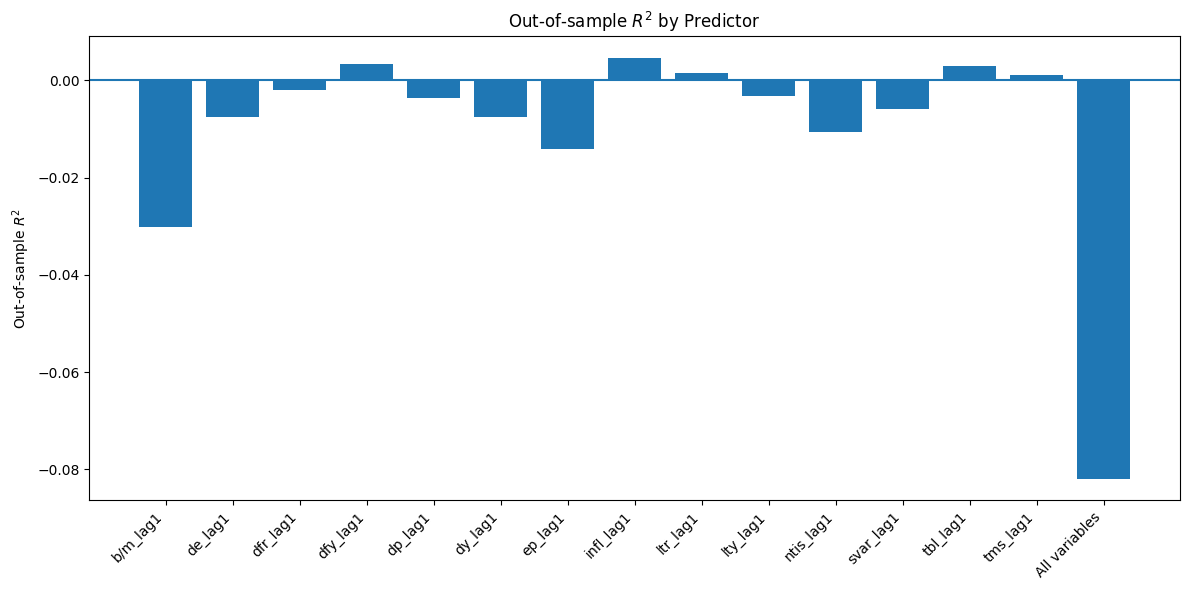

In [12]:
last_info = df_exercise_2_1[df_exercise_2_1.index == df_exercise_2_1.index.max()][["r_squared_oos"]]
last_info.index = ["All variables"]

df_just_oos = pd.concat([df_exercise_1_2[["r_squared_oos"]], last_info], axis = 0)

variables = df_just_oos.index
r2_oos = df_just_oos["r_squared_oos"].values

x = np.arange(len(variables))

plt.figure(figsize=(12, 6))
plt.bar(x, r2_oos)
plt.axhline(0)
plt.xticks(x, variables, rotation=45, ha="right")
plt.ylabel("Out-of-sample $R^2$")
plt.title("Out-of-sample $R^2$ by Predictor")

plt.tight_layout()
plt.show()

Now incorporate a penalty term into the regression to counteract overfitting. Compute results for lasso, ridge, and elastic net, and use K-fold cross-validation to select the optimal penalty term. Plot the out-of-sample $R^2$ for each month for each of the three methods, along with the unpenalized regression. How do the methods compare? What does this tell us about the predictability of market returns?

__In the first years of the sample, the graph shows that the out-of-sample $R^2$ is unstable across all models. However, as more data are used to fit the models, the out-of-sample performance stabilizes.__

__The multivariate linear regression exhibits the worst performance due to multicollinearity issues: several predictors are highly correlated, which introduces additional noise and leads to overfitting. Penalized regressions perform better because they mitigate multicollinearity through coefficient shrinkage.__

__Nevertheless, these improvements are limited, as the out-of-sample $R^2$ remains close to zero. In the case of Ridge regression, it becomes slightly positive, but the magnitude is small. Overall, these results indicate that achieving reliable predictability of market returns using these models remains challenging.__

In [13]:
#Calculating Rsquared per variable using a rolling window
info_list_errors_multivariable = [] 


alphas = np.logspace(-4, 4, 50)
for future_date in list_future_dates:
    #Cleaning data
    df_equity_aux_train = df_equity[df_equity.index < future_date]
    df_equity_aux_test = df_equity[df_equity.index == future_date]
    
    y_rolling = df_equity_aux_train[dep_variable].to_numpy()
    y_rolling_test = df_equity_aux_test[dep_variable].to_numpy()

    X_rolling = df_equity_aux_train[indep_variable_list].to_numpy()
    X_rolling_test = df_equity_aux_test[indep_variable_list].to_numpy()

    #Fitting models
    lasso_model = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LassoCV(cv=5, random_state=0))
            ])
    lasso_model.fit(X_rolling, y_rolling)

    ridge_model = Pipeline([
            ("scaler", StandardScaler()),
            ("model", RidgeCV(alphas=alphas, cv=5))
            ])
    ridge_model.fit(X_rolling, y_rolling)

    net_model = Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNetCV(
            l1_ratio=[0.2, 0.5, 0.8],
            cv=5,
            random_state=0
            ))
        ])
    net_model.fit(X_rolling, y_rolling)

    #Predicting future values
    y_hat_lasso = lasso_model.predict(X_rolling_test)
    y_hat_ridge = ridge_model.predict(X_rolling_test)
    y_hat_net = net_model.predict(X_rolling_test)

    #Calculating erroes 
    squared_forecast_error_lasso = (y_rolling_test - y_hat_lasso) ** 2
    squared_forecast_error_ridge = (y_rolling_test - y_hat_ridge) ** 2
    squared_forecast_error_net = (y_rolling_test - y_hat_net) ** 2

    squared_benchmark_error = (y_rolling_test - y_rolling.mean()) ** 2

    info_list_errors_multivariable.append([future_date, 
                                           squared_forecast_error_lasso[0], 
                                           squared_forecast_error_ridge[0], 
                                           squared_forecast_error_net[0], 
                                           squared_benchmark_error[0]])


df_exercise_2_2 = pd.DataFrame(info_list_errors_multivariable, columns = ["date", "lasso", "ridge", "net" ,"squared_benchmark_error"])
df_exercise_2_2.set_index("date", inplace = True)
df_exercise_2_2 = df_exercise_2_2.cumsum()
df_exercise_2_2["r_squared_oos_lasso"] = 1 - (df_exercise_2_2["lasso"] / df_exercise_2_2["squared_benchmark_error"])
df_exercise_2_2["r_squared_oos_ridge"] = 1 - (df_exercise_2_2["ridge"] / df_exercise_2_2["squared_benchmark_error"])
df_exercise_2_2["r_squared_oos_net"] = 1 - (df_exercise_2_2["net"] / df_exercise_2_2["squared_benchmark_error"])

In [14]:
df_oos_linear_models = pd.concat([df_exercise_2_1.filter(like = "r_squared_oos"),df_exercise_2_2.filter(like = "r_squared_oos")], axis = 1)
df_oos_linear_models.columns = ["Multilinear regression", "Lasso regression", "Ridge regression", "Elastic Net regression"]

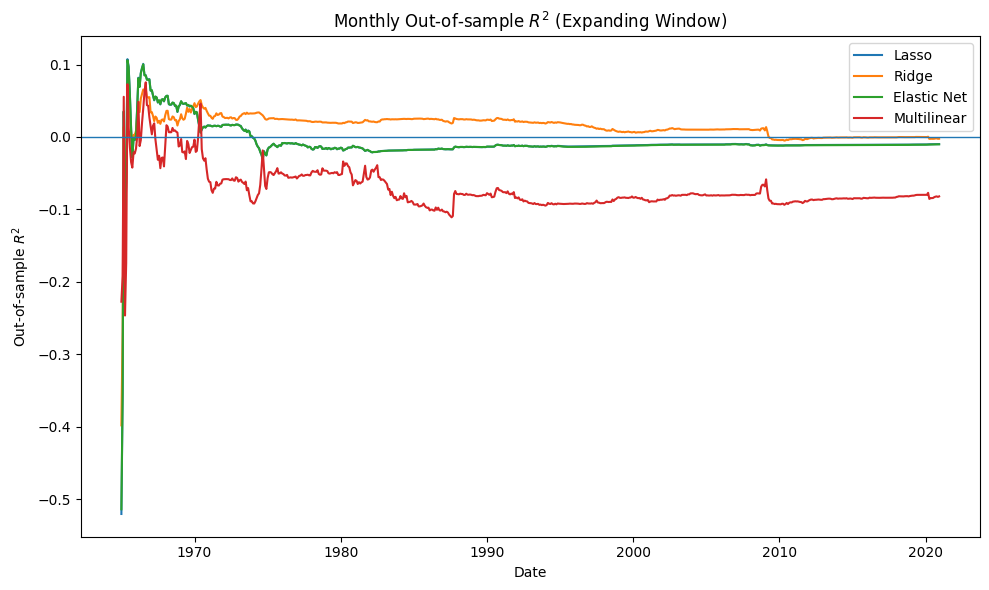

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(df_oos_linear_models.index, df_oos_linear_models["Lasso regression"], label="Lasso")
plt.plot(df_oos_linear_models.index, df_oos_linear_models["Ridge regression"], label="Ridge")
plt.plot(df_oos_linear_models.index, df_oos_linear_models["Elastic Net regression"], label="Elastic Net")
plt.plot(df_oos_linear_models.index, df_oos_linear_models["Multilinear regression"], label="Multilinear")

plt.axhline(0, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Out-of-sample $R^2$")
plt.title("Monthly Out-of-sample $R^2$ (Expanding Window)")
plt.legend()

plt.tight_layout()
plt.show()

## Exercise 3

Next, lets introduce some non-linearities into the model. Use the radial basis function kernel to generate non-linear expansions of the underlying predictor set (use the RBFSampler1 from sklearn). Generate these features for a number of different feature counts. Plot the out-of-sample R2 as a function of the number of features generated by the kernel. 

* How do the results compare to the linear models? 

__Using the RBFSampler combined with Ridge regression (the best-performing linear benchmark), the nonlinear models exhibit worse out-of-sample performance than the linear specifications. In particular, as the number of generated features increases, the out-of-sample $R^2$ becomes more negative, indicating increased overfitting and no improvement in predictive power.__

* Interpret the importance of the number of features in the kernel expansion.

__The out-of-sample $R^2$ in the RBF-based model is highly sensitive to the number of generated features. While a small number of features leads to relatively more stable performance, increasing the feature count deteriorates the out-of-sample fit. This highlights the importance of controlling model complexity. In this application, a moderate number of features (approximately between 20 and 100) provides the best trade-off between flexibility and overfitting..__ 

In [45]:
#Calculating Rsquared per variable using a rolling window
info_list_errors_rbf = [] 
list_parameters = [20, 50, 100, 200, 400]

for param_indiv in list_parameters:

    for future_date in list_future_dates:
        df_equity_aux_train = df_equity[df_equity.index < future_date]
        df_equity_aux_test = df_equity[df_equity.index == future_date]
    
        y_rolling = df_equity_aux_train[dep_variable].to_numpy()
        y_rolling_test = df_equity_aux_test[dep_variable].to_numpy()

        X_rolling = df_equity_aux_train[indep_variable_list].to_numpy()
        X_rolling_test = df_equity_aux_test[indep_variable_list].to_numpy()

        rbf_model = pipe_rbf = Pipeline([
        ("scaler", StandardScaler()),
        ("rbf", RBFSampler(
            gamma=0.5,
            n_components=param_indiv,
            random_state=0
            )),
            ("model", Ridge(alpha=1.0))
            ])
    
        rbf_model.fit(X_rolling, y_rolling)

        y_hat_rolling = rbf_model.predict(X_rolling_test)

        squared_forecast_error = (y_rolling_test - y_hat_rolling) ** 2
        squared_benchmark_error = (y_rolling_test - y_rolling.mean()) ** 2

        info_list_errors_rbf.append([future_date, param_indiv, squared_forecast_error[0], squared_benchmark_error[0]])


df_exercise_3_1 = pd.DataFrame(info_list_errors_rbf, columns = ["date", "num_features","squared_forecast_error", "squared_benchmark_error"])
df_squared_forecast = pd.pivot_table(df_exercise_3_1, index = ["date"], columns = ["num_features"], values = ["squared_forecast_error"], aggfunc = "sum")
df_squared_forecast.columns = df_squared_forecast.columns.droplevel(0)
df_benchmark_forecast = pd.pivot_table(df_exercise_3_1, index = ["date"], columns = ["num_features"], values = ["squared_benchmark_error"], aggfunc = "sum")
df_benchmark_forecast.columns = df_benchmark_forecast.columns.droplevel(0)
df_oos_exercise_3_1 = 1 - (df_squared_forecast.cumsum()/ df_benchmark_forecast.cumsum())

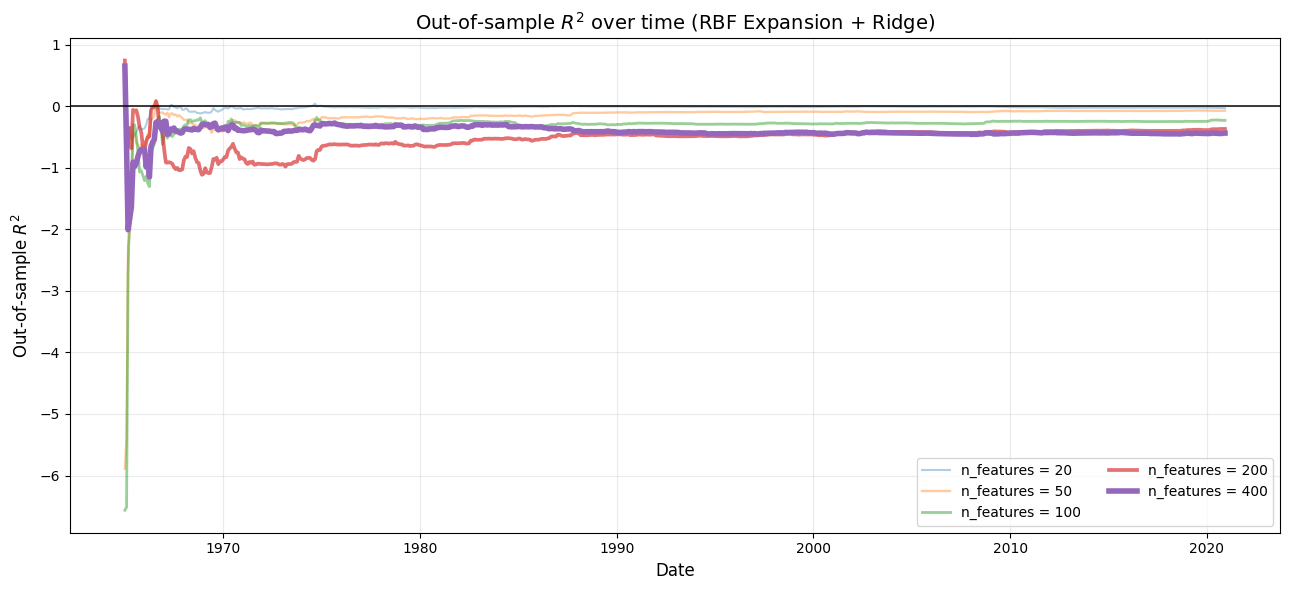

In [49]:
df_plot = df_oos_exercise_3_1.copy()
features = df_plot.columns.tolist()

# Normalizar para alpha y linewidth
min_f, max_f = min(features), max(features)

def scale(val, vmin, vmax, new_min, new_max):
    return new_min + (val - vmin) * (new_max - new_min) / (vmax - vmin)

plt.figure(figsize=(13, 6))

for f in features:
    lw = scale(f, min_f, max_f, 1.5, 4.0)     # grosor
    alpha = scale(f, min_f, max_f, 0.35, 1.0) # opacidad

    plt.plot(
        df_plot.index,
        df_plot[f],
        linewidth=lw,
        alpha=alpha,
        label=f"n_features = {f}"
    )

# Línea de referencia
plt.axhline(0, color="black", linewidth=1.2, alpha=0.9)

plt.title("Out-of-sample $R^2$ over time (RBF Expansion + Ridge)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Out-of-sample $R^2$", fontsize=12)

plt.grid(True, alpha=0.25)
plt.legend(ncol=2, frameon=True)
plt.tight_layout()
plt.show()

## Exercise 4

To what extent do our results depend on the training window? Refit the model from part (3) using a rolling window of 12, 36, 60, and 120 months. What do you observe about the out-of-sample R2 as the training window changes?

__he out-of-sample $R^2$ stabilizes faster when larger training samples are used compared to shorter ones. The shortest training windows produce the worst results, showing higher volatility and more negative performance. In contrast, the expanding window and the 500-month rolling window yield more stable and relatively better out-of-sample results.__

In [95]:
#Calculating Rsquared per variable using a rolling window

list_window = [12, 36, 60, 120, 500]

list_errors_windows = []

for window in list_window:

    info_list_errors_rbf = [] 

    for i in range(df_equity.shape[0]-window): 
        df_equity_aux_train = df_equity.iloc[i:(i+window),:]
        df_equity_aux_test = df_equity.iloc[i+window,:]
    
        y_rolling = df_equity_aux_train[dep_variable].to_numpy()
        y_rolling_test = df_equity_aux_test[dep_variable]

        X_rolling = df_equity_aux_train[indep_variable_list].to_numpy()
        X_rolling_test = df_equity_aux_test[indep_variable_list].to_numpy().reshape(1, -1)

        rbf_model = pipe_rbf = Pipeline([
        ("scaler", StandardScaler()),
        ("rbf", RBFSampler(
            gamma=0.5,
            n_components=20,
            random_state=0
            )),
            ("model", Ridge(alpha=1.0))
            ])
    
        rbf_model.fit(X_rolling, y_rolling)

        y_hat_rolling = rbf_model.predict(X_rolling_test)

        squared_forecast_error = (y_rolling_test - y_hat_rolling) ** 2
        squared_benchmark_error = (y_rolling_test - y_rolling.mean()) ** 2

        info_list_errors_rbf.append([df_equity_aux_test.name, squared_forecast_error, squared_benchmark_error])

    df_aux = pd.DataFrame(info_list_errors_rbf, columns = ["date", "squared_forecast_error", "squared_benchmark_error"])
    df_aux.set_index("date", inplace = True)
    df_oos_window = 1 - (df_aux["squared_forecast_error"].cumsum()/ df_aux["squared_benchmark_error"].cumsum())
    list_errors_windows.append(df_oos_window)

df_oos_general_windows = pd.concat(list_errors_windows, axis = 1).astype(float)
df_oos_general_windows.columns = list_window

df_expanding = df_oos_exercise_3_1[[20]].copy()
df_expanding.columns = ["Expanding"]

df_oos_general_windows = pd.concat([df_oos_general_windows, df_expanding], axis = 1)

/var/folders/6b/49w6824d2lzg0z0wl401c5m80000gn/T/ipykernel_2457/2796200870.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")


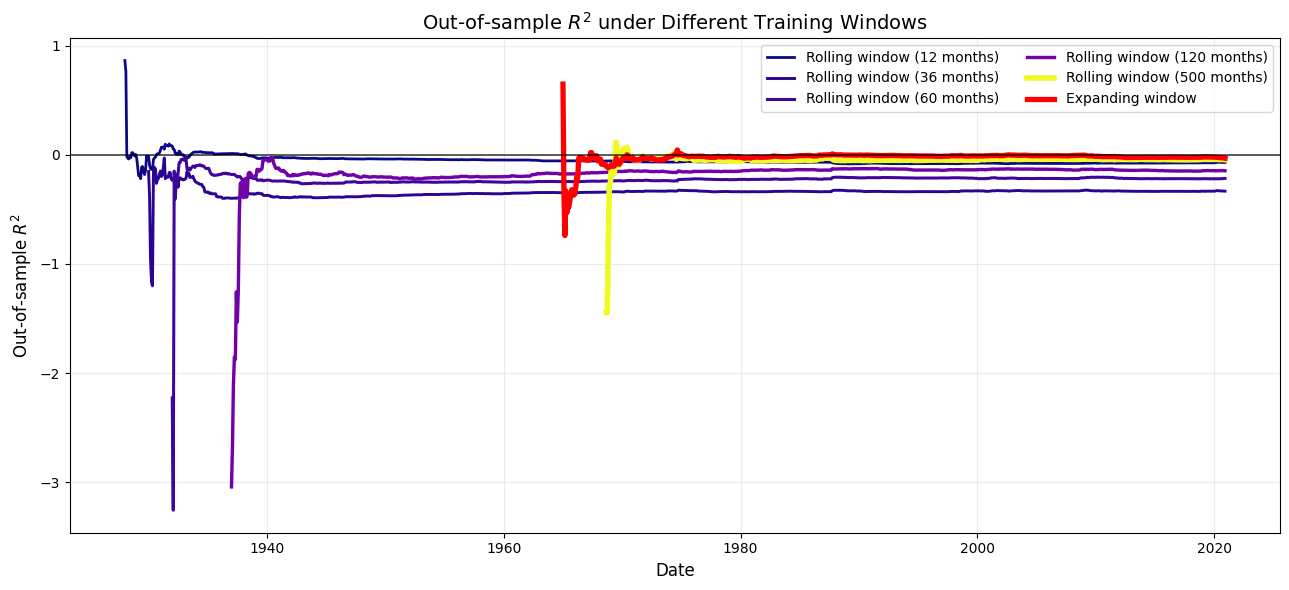

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

df_plot = df_oos_general_windows.copy()

plt.figure(figsize=(13, 6))

# Rolling windows with plasma colormap
rolling_cols = sorted([c for c in df_plot.columns if c != "Expanding"])
norm = plt.Normalize(min(rolling_cols), max(rolling_cols))
cmap = cm.get_cmap("plasma")

for w in rolling_cols:
    color = cmap(norm(w))
    lw = 2.0 + 2.0 * norm(w)  # thicker for larger windows

    plt.plot(
        df_plot.index,
        df_plot[w],
        color=color,
        linewidth=lw,
        label=f"Rolling window ({w} months)"
    )

# Expanding window in red
plt.plot(
    df_plot.index,
    df_plot["Expanding"],
    color="red",
    linewidth=3.8,
    label="Expanding window"
)

plt.axhline(0, color="black", linewidth=1.1, alpha=0.8)

plt.title("Out-of-sample $R^2$ under Different Training Windows", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Out-of-sample $R^2$", fontsize=12)

plt.grid(True, alpha=0.25)
plt.legend(ncol=2, frameon=True)
plt.tight_layout()
plt.show()

## Exercise 5

To what extent do our results depend on the cross-validation method? Refit the model from part (3) using a range of folds for cross-validation. What do you observe about the out-of-sample R2 as the number of folds changes?

__The out-of-sample $R^2$ deteriorates when a small number of cross-validation folds is used, whereas it remains largely stable as the number of folds increases__

In [ ]:
#Calculating Rsquared per variable using a rolling window
info_list_errors_rbf = [] 
list_parameters = [3, 5, 10, 20]

for param_indiv in list_parameters:

    for future_date in list_future_dates:
        df_equity_aux_train = df_equity[df_equity.index < future_date]
        df_equity_aux_test = df_equity[df_equity.index == future_date]
    
        y_rolling = df_equity_aux_train[dep_variable].to_numpy()
        y_rolling_test = df_equity_aux_test[dep_variable].to_numpy()

        X_rolling = df_equity_aux_train[indep_variable_list].to_numpy()
        X_rolling_test = df_equity_aux_test[indep_variable_list].to_numpy()

        rbf_model = pipe_rbf = Pipeline([
        ("scaler", StandardScaler()),
        ("rbf", RBFSampler(
            gamma=0.5,
            n_components=20,
            random_state=0
            )),
            ("model", RidgeCV(alphas=np.logspace(-3, 3, 15), cv = param_indiv))
            ])
    
        rbf_model.fit(X_rolling, y_rolling)

        y_hat_rolling = rbf_model.predict(X_rolling_test)

        squared_forecast_error = (y_rolling_test - y_hat_rolling) ** 2
        squared_benchmark_error = (y_rolling_test - y_rolling.mean()) ** 2

        info_list_errors_rbf.append([future_date, param_indiv, squared_forecast_error[0], squared_benchmark_error[0]])


df_exercise_5_1 = pd.DataFrame(info_list_errors_rbf, columns = ["date", "num_folds","squared_forecast_error", "squared_benchmark_error"])
df_squared_forecast = pd.pivot_table(df_exercise_5_1, index = ["date"], columns = ["num_folds"], values = ["squared_forecast_error"], aggfunc = "sum")
df_squared_forecast.columns = df_squared_forecast.columns.droplevel(0)
df_benchmark_forecast = pd.pivot_table(df_exercise_5_1, index = ["date"], columns = ["num_folds"], values = ["squared_benchmark_error"], aggfunc = "sum")
df_benchmark_forecast.columns = df_benchmark_forecast.columns.droplevel(0)
df_oos_exercise_5_1 = 1 - (df_squared_forecast.cumsum()/ df_benchmark_forecast.cumsum())

/var/folders/6b/49w6824d2lzg0z0wl401c5m80000gn/T/ipykernel_2457/747839624.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")


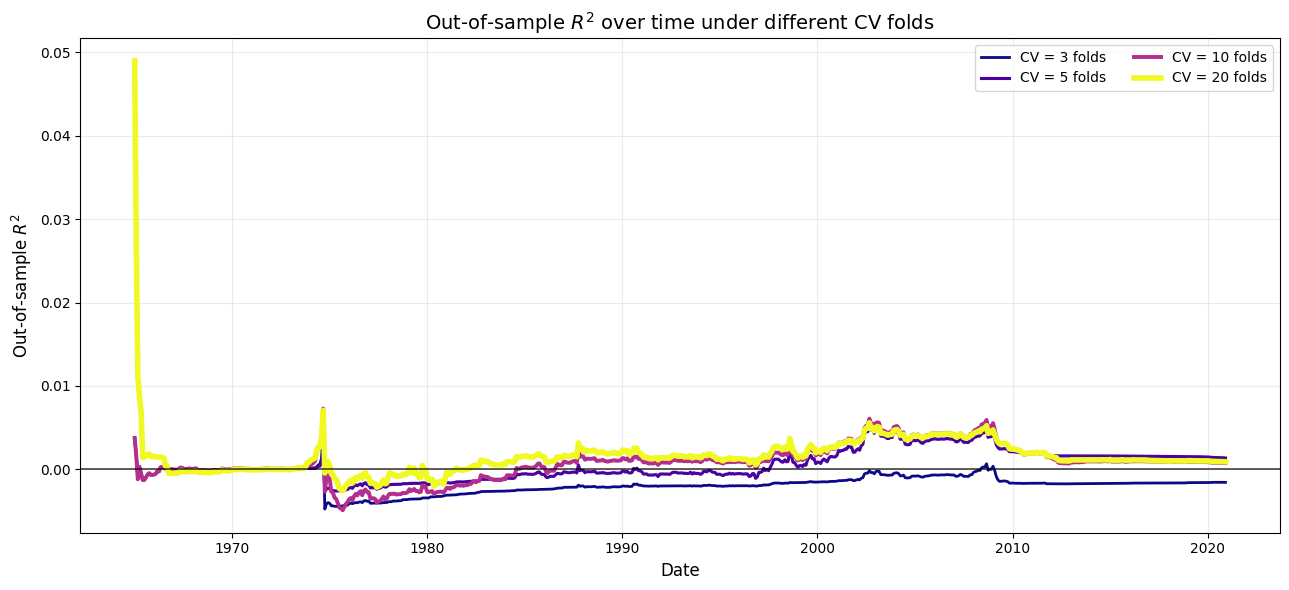

In [108]:
df_plot = df_oos_exercise_5_1.copy()

plt.figure(figsize=(13, 6))

# CV folds as columns
cv_cols = df_plot.columns.tolist()
cv_cols = sorted(cv_cols)  # [3, 5, 10, 20]

# Use a perceptual colormap for contrast
norm = plt.Normalize(min(cv_cols), max(cv_cols))
cmap = cm.get_cmap("plasma")

for cv in cv_cols:
    color = cmap(norm(cv))
    lw = 2.0 + 2.0 * norm(cv)   # more folds → thicker line
    alpha = 0.9                # keep all visible

    plt.plot(
        df_plot.index,
        df_plot[cv],
        color=color,
        linewidth=lw,
        label=f"CV = {cv} folds"
    )

# Reference line at zero
plt.axhline(0, color="black", linewidth=1.1, alpha=0.8)

plt.title("Out-of-sample $R^2$ over time under different CV folds", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Out-of-sample $R^2$", fontsize=12)

plt.grid(True, alpha=0.25)
plt.legend(ncol=2, frameon=True)
plt.tight_layout()
plt.show()

## Exercise 6

Next, download the FREDMD.csv file from canvas. Incorporate the macroeconomic variables from this file into the model from part (c). How do the out-of-sample $R^2$ change when we include these variables? What does this tell us about the virtue of complexity?

In [116]:
df_other_variables = pd.read_csv(path + other_variables_file)
df_other_variables.set_index("date", inplace = True)

In [120]:
df_full = pd.merge(df_equity,df_other_variables, how = "left", left_index= True, right_index = True)

In [127]:
df_full.dropna(axis = 0)

,dfy_lag1,infl_lag1,svar_lag1,de_lag1,lty_lag1,tms_lag1,tbl_lag1,dfr_lag1,dp_lag1,dy_lag1,...,AAAFFM,BAAFFM,TWEXAFEGSMTHx,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,OILPRICEx,UMCSENTx,VIXCLSx
date,,,,,,,,,,,,,,,,,,,,,
